## Yum or Yuck Butterfly Mimics 2022 – Load Test Images

**Author:** [Keith Pinson](https://github.com/keithpinson)<br>
**Date created:** 2022/07/29<br>
**Version:** 1.0.0001<br>
**Description:** Example of how to load test images into a TensorFlow Dataset<br>
**Platform:** Kaggle Packages including Tensorflow 2.6.4 with GPU support<br>
<br>


In [1]:
import datetime

print("executed",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"local time")

executed 2022-07-31 19:39:16 local time


---
## Set Environment
---


In [2]:
import os
import platform
import random

import tensorflow as tf

# Using TensorFlow's enhanced version of Numpy
import tensorflow.experimental.numpy as np
np.experimental_enable_numpy_behavior()

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt, patches

print(f"Tensorflow {tf.__version__}", "with GPU support" if len(tf.config.list_physical_devices('GPU')) > 0 else "for CPU only")

Tensorflow 2.6.3 with GPU support


### <u>Dataset paths and names</u>


In [3]:
os_system = platform.system()  # 'Windows', 'Linux'

hosted_by = 'Kaggle' if os.environ.get('KAGGLE_URL_BASE') else \
            ('Windows' if os.environ.get('WINDIR') else \
            'Unknown')

if hosted_by == 'Kaggle':
    dataset_name = "yum-or-yuck-butterfly-mimics-2022"

    # Setting the variables assuming a Kaggle platform
    base_dir = "/kaggle"
    data_dir = os.path.join(base_dir, 'input', dataset_name, 'data', 'butterfly_mimics')
    working_dir = os.path.join(base_dir, 'working')
    temp_dir = os.path.join(base_dir, 'temp')

elif hosted_by == 'Windows':
    dataset_name = "YOYMimics-2022-dataset"

    # Setting the variables assuming a Windows platform
    base_dir = "."
    data_dir = os.path.join(base_dir, dataset_name, 'data', 'butterfly_mimics')
    working_dir = os.path.join(os.environ.get("HOMEPATH"), dataset_name)
    temp_dir = os.path.join(os.environ.get("TMP"), dataset_name)

train_dir = os.path.join(data_dir, 'images')
test_dir = os.path.join(data_dir, 'image_holdouts')
train_csv = os.path.join(data_dir, 'images.csv')
test_csv = os.path.join(data_dir, 'image_holdouts.csv')
submit_csv = os.path.join(working_dir, 'submission.csv')

class_names = ['black', 'monarch', 'pipevine', 'spicebush', 'tiger', 'viceroy']
class_count = len(class_names)


---
## Build Dataset Pipeline
---


### <u>Load and Map Functions</u>

In [4]:
IMAGE_WIDTH = IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)  # Row,Column order
IMAGE_DEPTH = 3

butterfly_classes = np.array(class_names, dtype='str')

def get_feature_and_label_function(image_id, class_name):
    _image_id = image_id[0].decode('UTF-8')
    _class_name = class_name[0].decode('UTF-8')

    _img = tf.io.read_file(os.path.join(
        train_dir, _image_id + '.jpg'))

    _img = tf.image.decode_jpeg(_img,
        channels=IMAGE_DEPTH,
        dct_method='INTEGER_ACCURATE',
        name=_image_id)

    _img = tf.image.resize(_img,IMAGE_SIZE)

    _img = tf.cast(_img, tf.float32)/255.0

    name_label = tf.convert_to_tensor(_class_name)

    one_hot = name_label == butterfly_classes

    encoded_label = one_hot.astype(np.float32)

    return _img, encoded_label, image_id

def get_feature_and_label(x,y):

    features_labels = tf.numpy_function(
        get_feature_and_label_function,
        [x,y],
        [tf.float32,tf.float32,tf.string]
    )

    # numpy_function() loses the shapes, we will need to restore them

    features_labels[0].set_shape(
        tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    )

    features_labels[1].set_shape(tf.TensorShape([class_count]))

    features_labels[2].set_shape(tf.TensorShape([1]))
    tf.cast(features_labels[2], tf.string, name='image_id')

    return features_labels

def load_training(training_data : pd.core.frame.DataFrame):

    # Training Dataset
    images = pd.DataFrame(training_data[['image']].values.tolist())
    names = pd.DataFrame(training_data[['name']].values.tolist())

    _training_ds = tf.data.Dataset.from_tensor_slices((images,names))
    _training_ds = _training_ds.map(get_feature_and_label)

    return _training_ds

def decode_image(image):
    # image.shape == tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    return tf.keras.utils.array_to_img(image.numpy())

def decode_label(label):
    # label.shape == tf.TensorShape([class_count])
    return butterfly_classes[tf.argmax(label)].numpy().decode('UTF-8')

def decode_image_id(image_id):
    # image_id.shape == tf.TensorShape([1])
    return image_id.numpy()[0].decode('UTF-8')


### <u>Load the Training Images</u>

In [5]:
training_ds_encoded = load_training(pd.read_csv(train_csv))
training_ds = [(decode_image(m),decode_label(l),decode_image_id(id)) for (m, l, id) in training_ds_encoded]

training_ds[:5]

[(<PIL.Image.Image image mode=RGB size=224x224 at 0x184985D7288>,
  'monarch',
  'ggc1e08cbc'),
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x184AEF80D88>,
  'tiger',
  'gh150f104b'),
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x184AEF84308>,
  'black',
  'gh20ab0d9c'),
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x184AEF84808>,
  'monarch',
  'gh2d5c8c79'),
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x184AEF84908>,
  'pipevine',
  'gh6adf74a4')]

gm025be3d6.jpg monarch


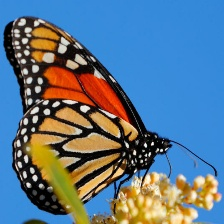

In [6]:
print(f"{training_ds[14][2]}.jpg {training_ds[14][1]}")
training_ds[14][0]

### <u>Show the Images</u>

In [7]:
j = 0

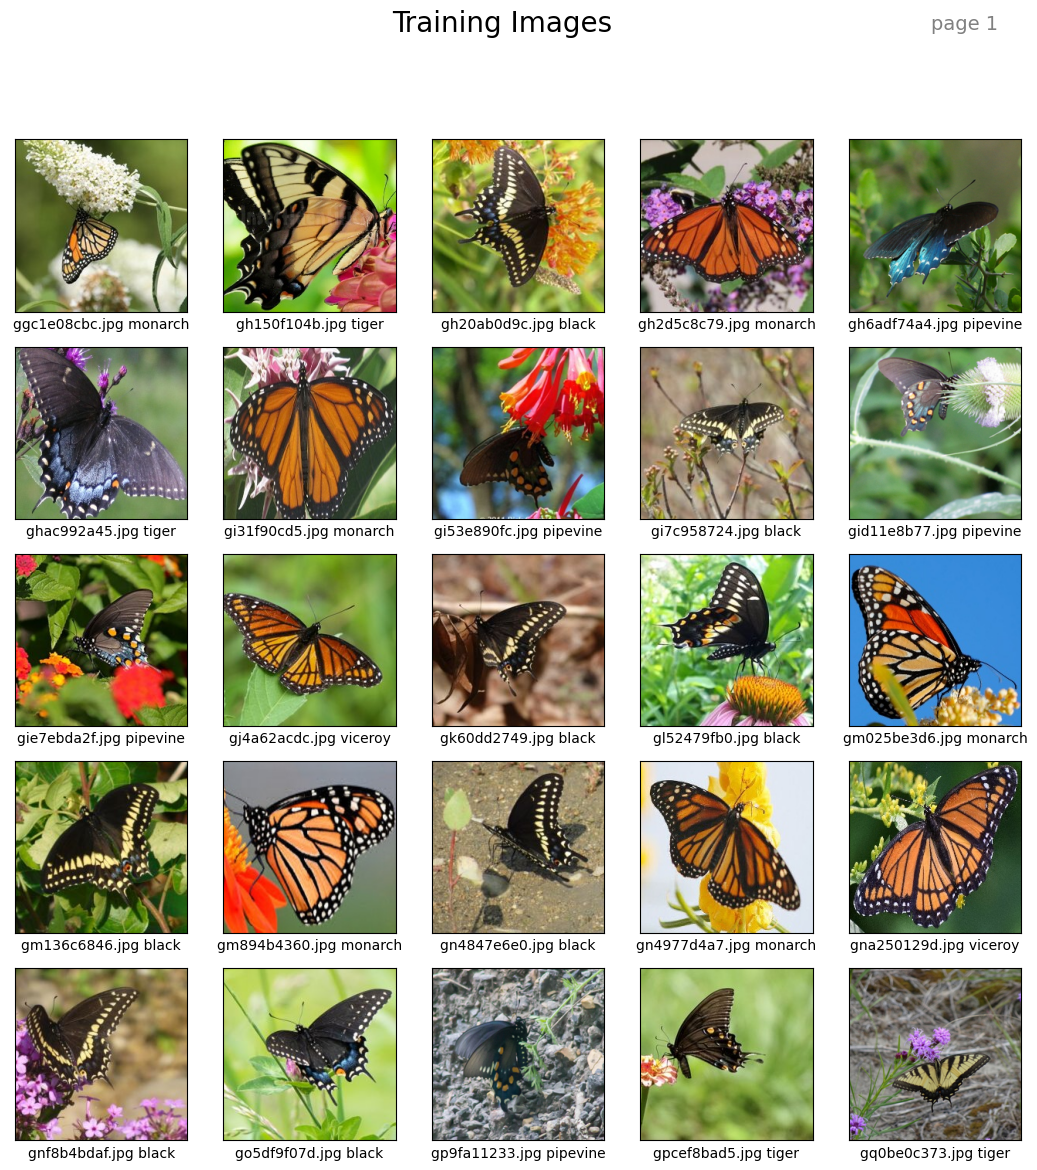

In [8]:
rows = 5
cols = 5

plt.style.use("default")

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(13, 13))

plt.suptitle("Training Images\n", fontsize=20)

maxloop = len(training_ds)//(rows*cols)

if j <= maxloop:
    for i, ax in enumerate(axs.flat):
        k = (j*rows*cols) + i

        if k < len(training_ds):

            ax.grid(None)
            ax.axis('on')

            ax.imshow(training_ds[k][0], interpolation_stage='rgb')
            ax.set(xticks=[], yticks=[], xlabel = f"{training_ds[k][2]}.jpg {training_ds[k][1]}")
        else:
            ax.set_visible(False)

    fig.text(.83, .965, f"page {j+1}", color='grey', fontsize=14)


    j = j + 1 if j < maxloop else 0
    plt.show()

---